# Federico Andrucci - 000105....

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.cluster import pair_confusion_matrix

# Variables
file_name = 'exam_2021_02_17_data.csv'
separator = '\t'
random_state = 42

# Directives
%matplotlib inline
np.random.seed(random_state)

## 1. Load the data, the attributes are all qualitative and there is no label column, show the shape of the data and for each column show the frequencies of each distinct value (hint: you can use the numpy function unique(x, return_counts = True)

In [2]:
# Load the data
X = pd.read_csv(file_name, delimiter=separator)

# Show the shepe of the data
print(f"The shape of the dataset is {X.shape}")

The shape of the dataset is (1000, 3)


In [3]:
# For each column show the frequencies of each distinct value
np.unique(X, return_counts=True)

(array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], dtype=object),
 array([300, 298, 300, 300, 302, 300, 300, 300, 300, 300]))

## 2. Do the appropriate pre-processing in order to use the sklearn algorithms on this dataset; the values are qualitative and must be considered as nominal

Since we have categorical fieatures we need to convert it as nominal

In [5]:
# we need to transform into integers
transf_dtype = np.int32
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=transf_dtype)

# fit and transform the data
X_p = one_hot_encoder.fit_transform(X)

## 3. As an external background knowledge, we are told that for this dataset a requirement for a good clustering scheme is to have clusters with low deviation in sizes, e.g. a scheme with cluster sizes (330, 670) is less acceptable than one with (333, 333, 334). 

In order to obtain this, we want to compute, for each clustering scheme with n_clusters clusters and represented by the labels in y, a size deviation index with the formula 

`np.sqrt(np.unique(y, return_counts = True)[1].var())/n_clusters`

For varying number of clusters fit KMeans and compute the inertia, the silhouette index and the above‑mentioned size deviation index.

In [6]:
# range of possible clusters
k_range = range(2, 11)

# distorition, silhouette score and size deviation as measure
distortions = []
silhouette_scores = []
size_deviations = []

for i in k_range:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=random_state)

    # fit predict
    y_km = km.fit_predict(X_p)

    # compute the deviation
    deviation = np.sqrt(np.unique(y_km, return_counts=True)[1].var())/i

    # store the data in the arrays
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_p, y_km))
    size_deviations.append(deviation)

## 4. In this dataset the elbow method will show an almost “vanishing” elbow for inertia, and the silhouette is totally non-effective. Make two plots, one with inertia and silhouette, another with inertia and size deviation index, then decide the best number of clusters and refit KMeans using that value

We will first plot inertia and silhouette

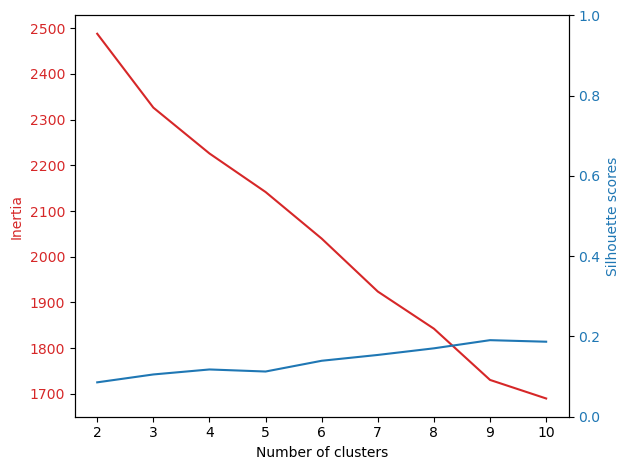

In [7]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1)

fig.tight_layout()
plt.show()

As we can see, the inertia decrease linearly, without showing any elbow, and the silhouette scores are indeed all very low.

We will now plot the inertia and the deviation size.

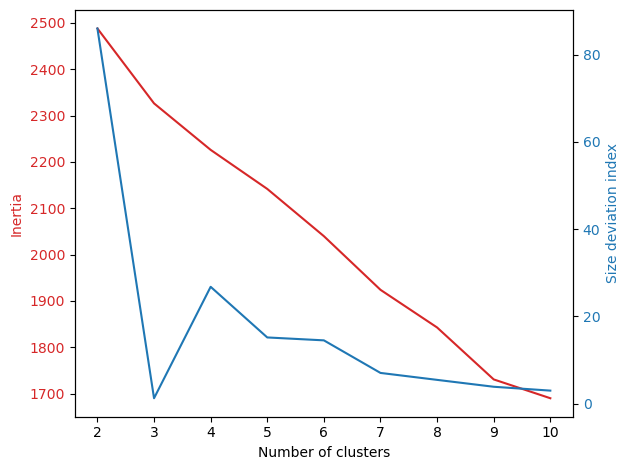

In [12]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Size deviation index', color=color)
ax2.plot(k_range, size_deviations, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Our goal is to minimize the size deviation index. So, the best compromise is probably 3 clusters. 

In [13]:
best_k = 3

## 5. Fit another clustering method of your choice, trying to reproduce the same number of clusters you have chosen in the previous step

For the 2nd method, we will use DBSCAN.

In order to fit the appropriate set of parameters value we will use `ParameterGrid`

In [14]:
# We will use a set of "reasonable" parameters to iterate over in our search
# eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
param_grid = {'eps': list(np.arange(1, 30, 1)), 'min_samples': list(range(50,300,5))}
params = list(ParameterGrid(param_grid))

In [16]:
print("{:11}\t{:11}\t{:11}\t{:11}\t{:11}\t{:11}".format('        eps','min_samples',' n_clusters',' silhouette', '    unclust%', '    size deviation'))
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X_p)
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    if n_clusters > 1:
        X_cl = X_p[y_db!=-1,:]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(X_cl,y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        s_deviation = np.sqrt(np.unique(y_km, return_counts = True)[1].var())/n_clusters
        print("{:11.2f}\t{:11}\t{:11}\t{:11.2f}\t{:11.2f}\t{:11.2f}"\
                  .format(db.eps, db.min_samples, n_clusters, silhouette, uncl_p, s_deviation))

        eps	min_samples	 n_clusters	 silhouette	    unclust%	    size deviation
       2.00	        280	          2	       0.06	      38.30	      14.86


Oddly enough, DBSCAN finds only huge amounts of clusters with our typical set of values (`{'eps': list(np.arange(0.1, 0.4, 0.01)), 'min_samples': list(range(1,10,1))}`), always 246 or 333 clusters.

In order to obtain a more similar amount of clusters, we had to change a lot the parameters, using `{'eps': list(np.arange(1, 30, 1)), 'min_samples': list(range(50,300,5))}`.

With those parameters, we found 2 clusters but with a very high unclustered percentage, 38.30%, meaning the clustering quality is quite poor. Also, the number of clusters that we found is not the same one as the one we had found with Kmeans.


## 6. Compare the results of the two clustering showing the result of sklearn.metrics.cluster.pair_confusion_matrix and sklearn.metrics.adjusted_rand_score

Before comparing the two clustering schemes, we will refit the two clustering algorithms with the results that we found.

In [21]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=random_state)
db = DBSCAN(eps=2.00, min_samples=200)

# fit and predict
y_km = km.fit_predict(X_p)
y_db = db.fit_predict(X_p)

Now that we have the predicted labels, we can compare them.

Note: both the functions are supposed to work with true labels and predicted labels, but since we don't have the "true" labels, we will have to settle with the two predicted ones.

In [22]:
adjusted_rand_score(y_km, y_db)

0.0

The adjusted rand score is very low, meaning that the two clusterings are quite different. This doesn't come as a surprise, as we ended up having two different values of the number of clusters.

In [23]:
pair_confusion_matrix(y_km, y_db)

array([[     0, 666626],
       [     0, 332374]])

Again, the numbers in this matrix show that the two cluster schemas are quite different 